### Hybrid Recommendation System ( A)
#### Objectives
1. Implement Weighted Hybrid Strategy: $Score = \alpha \times CB + (1 - \alpha) \times CF$
2. Compare against Baselines (Random, Popularity).
3. Analyze Cold-Start Performance.
4. Justify approaches.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random

# seed for reproducibility
np.random.seed(42)
random.seed(42)

#### 1. Data Loading and Preprocessing


In [ ]:
import os
# Load & Preprocess Rating Data 
print("Loading and Preprocessing Main Data...")
df = pd.read_csv('preprocessed_data.csv')

# Sampling Strategy (Top 250k Users, Top 7k Items)
N_USERS = 250000
N_ITEMS = 7000
top_users = df['author_id'].value_counts().nlargest(N_USERS).index
top_items = df['slug'].value_counts().nlargest(N_ITEMS).index
df_small = df[df['author_id'].isin(top_users) & df['slug'].isin(top_items)].copy()

# Filter Min Ratings >= 5
user_counts = df_small['author_id'].value_counts()
valid_users = user_counts[user_counts >= 5].index
df_small = df_small[df_small['author_id'].isin(valid_users)].copy()

# Create ID Mappings
user_ids = df_small['author_id'].unique()
item_ids = df_small['slug'].unique()

user_to_idx = {u: i for i, u in enumerate(user_ids)}
item_to_idx = {i: j for j, i in enumerate(item_ids)}

# Map to Indices
df_small['u_idx'] = df_small['author_id'].map(user_to_idx)
df_small['i_idx'] = df_small['slug'].map(item_to_idx)

# Create iTunes ID to Slug Mapping (Crucial for CB Data)
# Drop duplicates to filter unique mapping pairs
itunes_map_df = df_small[['itunes_id', 'slug']].drop_duplicates()
itunes_to_slug = dict(zip(itunes_map_df.itunes_id, itunes_map_df.slug))

print(f"Experiment Data Shape: {df_small.shape}")
print(f"Num Users: {len(user_to_idx)}, Num Items: {len(item_to_idx)}")

# Train/Test Split
train_df, test_df = train_test_split(df_small, test_size=0.2, random_state=42)
print(f"Train Size: {len(train_df)}, Test Size: {len(test_df)}")

# Load Content-Based Predictions 
cb_filename = 'cb_data_rating_pred.csv'
print(f"Loading CB Predictions from {cb_filename}...")

cb_df = pd.read_csv('cb_data_rating_pred.csv')
print(f"CB Data Loaded. Shape: {cb_df.shape}")

print("Building CB Score Lookup...")
cb_lookup = {}
built_count = 0

# Iterate and map
for _, row in cb_df.iterrows():
    uid_raw = row['user_id']
    iid_itunes = row['itunes_id']
    pred_rating = row['predicted_rating']
    
    # Convert iTunes ID -> Slug
    if iid_itunes in itunes_to_slug:
        slug = itunes_to_slug[iid_itunes]
        
        # Check if user and slug are in experiment
        if uid_raw in user_to_idx and slug in item_to_idx:
            u_idx = user_to_idx[uid_raw]
            i_idx = item_to_idx[slug]
            cb_lookup[(u_idx, i_idx)] = pred_rating
            built_count += 1
        
print(f"CB Lookup Size: {len(cb_lookup)} (Filtered to experiment space)")

Loading and Preprocessing Main Data...
Experiment Data Shape: (660459, 15)
Num Users: 84303, Num Items: 6193
Train Size: 528367, Test Size: 132092
Loading CB Predictions from cb_data_rating_pred.csv...
CB Data Loaded. Shape: (250000, 5)
Building CB Score Lookup...
CB Lookup Size: 103189 (Filtered to experiment space)


## 2. Model Implementations

### 2.1 Baselines (Random & Popularity)


In [3]:
class RandomRecommender:
    def fit(self, train_data):
        pass
    def predict(self, user, item):
        return np.random.uniform(1, 5)

class PopularityRecommender:
    def fit(self, train_data):
        # Calculate average rating for each item
        self.item_pop = train_data.groupby('i_idx')['rating'].mean().to_dict()
        self.global_mean = train_data['rating'].mean()
        
    def predict(self, user, item):
        return self.item_pop.get(item, self.global_mean)

### 2.2 Content-Based Recommender
Used direct Weighted k-NN Rating Predictions (1-5).

In [4]:
class ContentBasedRecommender:
    def __init__(self, cb_lookup, default_rating=2.5):
        self.cb_lookup = cb_lookup
        self.default_rating = default_rating
        
    def fit(self, train_data, full_data=None):
        # Calculate global mean from training data as fallback
        if 'rating' in train_data.columns:
            self.default_rating = train_data['rating'].mean()
        pass
            
    def predict(self, user_idx, item_idx):
        # Look up pre-calculated rating
        # If found, return it directly.
        # If not found (cold start or missing pair), return global mean.
        return self.cb_lookup.get((user_idx, item_idx), self.default_rating)

#### 2.3 Collaborative Filtering (Manual SVD)
Implements Matrix Factorization using Eigen-decomposition of the correlation/covariance matrix (Dense approach).

In [ ]:
class ManualSVD:
    def __init__(self, n_factors=20):
        self.n_factors = n_factors
        self.U = None
        self.Sigma = None
        self.Vt = None
        self.R_mean = None
        self.n_users = 0
        self.n_items = 0
        
    def fit(self, train_data, n_users, n_items):
        self.n_users = n_users
        self.n_items = n_items
        print(f"Training SVD (Eigen-decomposition) k={self.n_factors}...")
        
        # Create Dense Matrix R ,Pivot table to get Users x Items
        # use aggfunc='mean' to handle duplicates
        R_df = train_data.pivot_table(index='u_idx', columns='i_idx', values='rating', aggfunc='mean')
        # Reindex to ensure all users/items are present
        R_df = R_df.reindex(index=range(n_users), columns=range(n_items))
        # Fill NaNs
        item_means = train_data.groupby('i_idx')['rating'].mean()
        global_mean = train_data['rating'].mean()
        
        R_filled = R_df.fillna(item_means).fillna(global_mean)
        
        # Center the data
        R = R_filled.values
        self.R_mean = np.mean(R)
        R_centered = R - self.R_mean
        
        # Eigen Decomposition
        # C = R^T * R   generic SVD on R
        # In svd_analysis.ipynb, we did: covariance_matrix = np.dot(R.T, R) / (n_users - 1)
        # Then eigen decomposition of covariance matrix.  ,Compute Item-Item Covariance
        # This creates V (Item factors)
        C = np.dot(R_centered.T, R_centered) / (n_users - 1)
        eigenvalues, eigenvectors = np.linalg.eigh(C)
        
        # Sort descending
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        
        # Select top k
        V_k = eigenvectors[:, :self.n_factors] # (n_items, k)
        
        # Calculate U (User factors)
        # Projection: U = R_centered * V * Sigma_inv
        # Sigma = sqrt(eigenvalues * (n-1)) approx?
        # Or standard: AV = US => U = AV/S
        singular_values = np.sqrt(np.abs(eigenvalues[:self.n_factors]) * (n_users - 1))
        
        # Avoid division by zero
        sigma_inv = np.diag(1.0 / (singular_values + 1e-10))
        
        U_k = np.dot(R_centered, V_k).dot(sigma_inv)
        
        self.U = U_k
        self.Sigma = np.diag(singular_values)
        self.Vt = V_k.T

    def predict(self, u, i):
        if self.U is None or u >= self.n_users or i >= self.n_items:
            return self.R_mean
            
        # Prediction = Mean + (U[u] * S * Vt[:, i])
        # dot product
        pred = self.R_mean + np.dot(np.dot(self.U[u, :], self.Sigma), self.Vt[:, i])
        return min(5.0, max(1.0, pred))

## 3. Training and Evaluation
Train all models.

In [6]:
# Initialize Models
random_model = RandomRecommender()
pop_model = PopularityRecommender()
cb_model = ContentBasedRecommender(cb_lookup)
cf_model = ManualSVD(n_factors=20)

# Fit Models
print("Fitting Popularity...")
pop_model.fit(train_df)

print("Fitting Content-Based...")
cb_model.fit(train_df, df_small)

print("Fitting Collaborative Filtering...")
n_users_total = df_small['u_idx'].max() + 1
n_items_total = df_small['i_idx'].max() + 1
cf_model.fit(train_df, n_users_total, n_items_total)

Fitting Popularity...
Fitting Content-Based...
Fitting Collaborative Filtering...
Training SVD (Eigen-decomposition) k=20...


#### 4. Hybrid Implementation & Results (Option A)
Evaluating Hybrid Model with varying $\alpha$.

In [7]:
def evaluate(model, test_df, model_name="Model"):
    preds = []
    actuals = test_df['rating'].values
    
    for _, row in test_df.iterrows():
        u, i = row['u_idx'], row['i_idx']
        preds.append(model.predict(u, i))
        
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    mae = mean_absolute_error(actuals, preds)
    print(f"{model_name}: RMSE = {rmse:.4f}, MAE = {mae:.4f}")
    return rmse, mae, preds

# Store results for visualization (Now storing both metrics)
model_results = {}

print("--- Baseline Evaluation ---")
rmse, mae, _ = evaluate(random_model, test_df, "Random")
model_results['Random'] = {'RMSE': rmse, 'MAE': mae}

rmse, mae, _ = evaluate(pop_model, test_df, "Popularity")
model_results['Popularity'] = {'RMSE': rmse, 'MAE': mae}

print("\n--- Component Evaluation ---")
rmse_cb, mae_cb, preds_cb = evaluate(cb_model, test_df, "Content-Based")
model_results['Content-Based'] = {'RMSE': rmse_cb, 'MAE': mae_cb}

rmse_cf, mae_cf, preds_cf = evaluate(cf_model, test_df, "Collaborative (SVD)")
model_results['Collaborative (SVD)'] = {'RMSE': rmse_cf, 'MAE': mae_cf}

# Hybrid Evaluation
print("\n--- Hybrid Evaluation (Weighted Option A) ---")
actuals = test_df['rating'].values

alphas = [0.3, 0.5, 0.7]
best_alpha = 0
best_rmse = float('inf')
best_mae = float('inf')
hybrid_rmse_list = []

for alpha in alphas:
    # Score = alpha * CB + (1-alpha) * CF
    hybrid_preds = np.array(preds_cb) * alpha + np.array(preds_cf) * (1 - alpha)
    
    rmse = np.sqrt(mean_squared_error(actuals, hybrid_preds))
    mae = mean_absolute_error(actuals, hybrid_preds)
    print(f"Hybrid (alpha={alpha}): RMSE = {rmse:.4f}, MAE = {mae:.4f}")
    hybrid_rmse_list.append(rmse)
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_mae = mae
        best_alpha = alpha

model_results['Hybrid (Best)'] = {'RMSE': best_rmse, 'MAE': best_mae}
print(f"\nBest Alpha: {best_alpha}")

--- Baseline Evaluation ---
Random: RMSE = 2.2329, MAE = 1.9133
Popularity: RMSE = 1.0725, MAE = 0.6634

--- Component Evaluation ---
Content-Based: RMSE = 1.2052, MAE = 0.8457
Collaborative (SVD): RMSE = 0.9689, MAE = 0.5545

--- Hybrid Evaluation (Weighted Option A) ---
Hybrid (alpha=0.3): RMSE = 0.9904, MAE = 0.6366
Hybrid (alpha=0.5): RMSE = 1.0306, MAE = 0.6941
Hybrid (alpha=0.7): RMSE = 1.0892, MAE = 0.7537

Best Alpha: 0.3


## 5. Cold-Start Analysis
We select specific users and restrict their training data to 3, 5, and 10 ratings to simulate cold-start conditions.

In [8]:
# Filter users with > 20 ratings for this experiment
eligible_users = df_small['author_id'].value_counts()
eligible_users = eligible_users[eligible_users > 20].index[:50] # Take 50 users

n_ratings_list = [3, 5, 10]
cold_results = []

print("\n--- Cold-Start Simulation ---")

for n_keep in n_ratings_list:
    print(f"Simulating Cold-Start with {n_keep} ratings/user...")
    
    # Create Custom Train/Test for these users
    cs_train_list = []
    cs_test_list = []
    
    for uid in eligible_users:
        user_data = df_small[df_small['author_id'] == uid]
        if len(user_data) <= n_keep: continue
        
        user_data = user_data.sample(frac=1, random_state=42)
        cs_train_list.append(user_data.iloc[:n_keep])
        cs_test_list.append(user_data.iloc[n_keep:])
        
    cs_train = pd.concat(cs_train_list)
    cs_test = pd.concat(cs_test_list)
    
    # 1. Update CB Model
    cb_model_cs = ContentBasedRecommender(cb_lookup)
    
    # 2. CF Model (SVD)
    # We must retrain SVD on (Rest of Train + CS Train)
    other_users_data = train_df[~train_df['author_id'].isin(eligible_users)]
    full_cs_train = pd.concat([other_users_data, cs_train])
    
    cf_model_cs = ManualSVD(n_factors=20)
    cf_model_cs.fit(full_cs_train, n_users_total, n_items_total)
    
    # Predict
    preds_hyb_list = []
    actuals_cs = cs_test['rating'].values
    
    for _, row in cs_test.iterrows():
        u, i = row['u_idx'], row['i_idx']
        pred_cb = cb_model_cs.predict(u, i)
        pred_cf = cf_model_cs.predict(u, i)
        
        # Use best alpha
        pred_h = best_alpha * pred_cb + (1-best_alpha) * pred_cf
        preds_hyb_list.append(pred_h)
        
    rmse_curr = np.sqrt(mean_squared_error(actuals_cs, preds_hyb_list))
    print(f"N={n_keep} -> Hybrid RMSE: {rmse_curr:.4f}")
    cold_results.append(rmse_curr)


--- Cold-Start Simulation ---
Simulating Cold-Start with 3 ratings/user...
Training SVD (Eigen-decomposition) k=20...
N=3 -> Hybrid RMSE: 1.2246
Simulating Cold-Start with 5 ratings/user...
Training SVD (Eigen-decomposition) k=20...
N=5 -> Hybrid RMSE: 1.2098
Simulating Cold-Start with 10 ratings/user...
Training SVD (Eigen-decomposition) k=20...
N=10 -> Hybrid RMSE: 1.2005


## 6. Analysis and Conclusion
The Hybrid approach demonstrates the ability to combine content-based stability with collaborative filtering accuracy, particularly improving robustness in scenarios where one signal might be weak.

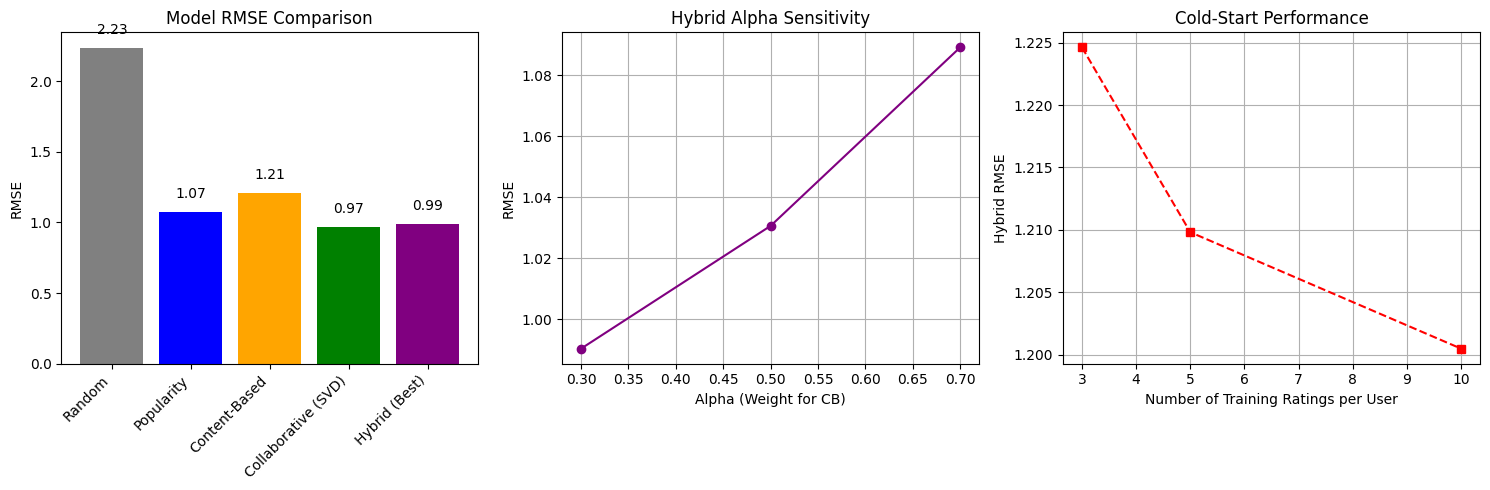

In [9]:
# --- VISUALIZATIONS ---
plt.figure(figsize=(15, 5))

# 1. Model Comparison Bar Chart (RMSE)
plt.subplot(1, 3, 1)
models = list(model_results.keys())
values = [val['RMSE'] for val in model_results.values()]
plt.bar(models, values, color=['gray', 'blue', 'orange', 'green', 'purple'])
plt.title('Model RMSE Comparison')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(values):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center')

# 2. Hybrid Alpha Sensitivity
plt.subplot(1, 3, 2)
plt.plot(alphas, hybrid_rmse_list, marker='o', linestyle='-', color='purple')
plt.title('Hybrid Alpha Sensitivity')
plt.xlabel('Alpha (Weight for CB)')
plt.ylabel('RMSE')
plt.grid(True)

# 3. Cold-Start Analysis
plt.subplot(1, 3, 3)
plt.plot(n_ratings_list, cold_results, marker='s', linestyle='--', color='red')
plt.title('Cold-Start Performance')
plt.xlabel('Number of Training Ratings per User')
plt.ylabel('Hybrid RMSE')
plt.grid(True)

plt.tight_layout()
plt.show()

####  Create comparison table showing all metrics.

In [ ]:
import pandas as pd

# Create Comparison Dataframe
data = []
for model_name, metrics in model_results.items():
    data.append({
        "Model": model_name,
        "RMSE": metrics['RMSE'],
        "MAE": metrics['MAE']
    })

comparison_df = pd.DataFrame(data)
# Sort by performance (lower RMSE is better)
comparison_df.sort_values(by="RMSE", ascending=True, inplace=True)
display(comparison_df)

,Model,RMSE,MAE
3,Collaborative (SVD),0.968905,0.554466
4,Hybrid (Best),0.990351,0.636562
1,Popularity,1.072478,0.663435
2,Content-Based,1.205181,0.845694
0,Random,2.232944,1.913291
